In [1]:
import sys
sys.path.append('../')
from utils import utils
import os
import datetime
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

In [2]:
DATA_FOLDER = '/project/cq-training-1/project1/data/hdf5v5_16bit/'
H5_PATH = os.path.join(DATA_FOLDER, '2014.07.11.0800.h5')

assert os.path.isfile(H5_PATH), f"invalid hdf5 path: {H5_PATH}"

In [3]:
# from https://github.com/mila-iqia/ift6759/blob/master/projects/project1/utils.py 

channel= 'ch6'
idx = 35
hdf5_path = H5_PATH
stations = {
    "BND": [40.05192, -88.37309, 230],
    "TBL": [40.12498, -105.23680, 1689],
    "DRA": [36.62373, -116.01947, 1007],
    "FPK": [48.30783, -105.10170, 634],
    "GWN": [34.25470, -89.87290, 98],
    "PSU": [40.72012, -77.93085, 376],
    "SXF": [43.73403, -96.62328, 473]
  }

image = None
stations_pixels_coords = None

with h5py.File(hdf5_path, "r") as h5_data:
    channel_idx_data = utils.fetch_hdf5_sample(channel, h5_data, idx)
    norm_min = h5_data[channel].attrs.get("orig_min", None)
    norm_max = h5_data[channel].attrs.get("orig_max", None)

    assert channel_idx_data is None or channel_idx_data.shape == (650, 1500), \
    "the channels had an unexpected dimension"

    # scales image
    array = (((channel_idx_data.astype(np.float32) - norm_min) / (norm_max - norm_min)) * 255).astype(np.uint8)

    if stations:
        lats, lons = utils.fetch_hdf5_sample("lat", h5_data, idx), utils.fetch_hdf5_sample("lon", h5_data, idx)
        assert lats is not None and lons is not None, "could not fetch lats/lons arrays (hdf5 might be empty)"

        stations_pixels_coords = {}
        for name, coords in stations.items():
            # converts station's lats and lons to horizontal and vertical pixels
            x = np.argmin(np.abs(lons - coords[1]))
            y = np.argmin(np.abs(lats - coords[0]))
            stations_pixels_coords[name] = (x,y)

    image = array

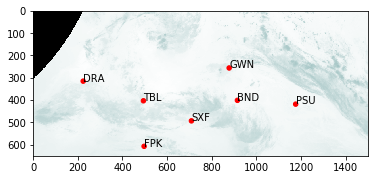

In [4]:
# show stations in channel and frame
# original array is horizontally flipped ('y' axis starts on top) 

fig, ax = plt.subplots(1)

# show the image
ax.imshow(image,cmap='bone')

if stations:
    for name, coords in stations_pixels_coords.items():
        circle = patches.Circle(coords, 10, color='r')
        ax.add_patch(circle)
        ax.annotate(name, coords)

plt.show()

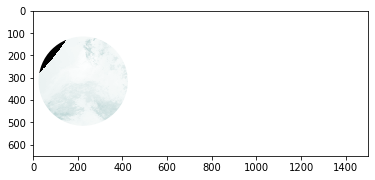

In [5]:
# https://matplotlib.org/gallery/images_contours_and_fields/image_clip_path.html#sphx-glr-gallery-images-contours-and-fields-image-clip-path-py

# display patch using station coordinates as center
station_coords = stations_pixels_coords['DRA']
patch_size = 200

fig, ax = plt.subplots(1)

# create patch
im = ax.imshow(image,cmap='bone')
patch = patches.Circle(station_coords, patch_size, transform=ax.transData)
im.set_clip_path(patch)

plt.show()

Checking lon and lat coordinates in h5 files

In [6]:
app_config = {
    "dataframe_path": "/project/cq-training-1/project1/data/dummy_test_catalog.pkl",
    "goes13_dataset": 'hdf516',
}

dataframe_path = app_config['dataframe_path']
catalog = pd.read_pickle(dataframe_path)

all_paths = catalog.groupby('hdf5_16bit_path').groups.keys()

print('> Amount of files/paths in catalog', len(all_paths))

ll_frame = 0
files_lats_lons = []
for path in all_paths:
    with h5py.File(path, "r") as h5_data:
        lats, lons = utils.fetch_hdf5_sample("lat", h5_data, ll_frame ), utils.fetch_hdf5_sample("lon", h5_data, ll_frame)
        
        if lats is not None and lons is not None:
            files_lats_lons.append({
                'lat_start': lats[0],
                'lat_end': lats[-1],
                'lon_start': lons[0],
                'lon_end': lons[-1]
            })
        else:
            print('Not found lons and lats for path:', path)

lats_longs_df = pd.DataFrame(files_lats_lons)

> Amount of files/paths in catalog 366


In [7]:
lats_longs_df.info()
lats_longs_df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 4 columns):
lat_start    366 non-null float64
lat_end      366 non-null float64
lon_start    366 non-null float64
lon_end      366 non-null float64
dtypes: float64(4)
memory usage: 11.6 KB


,lat_start,lat_end,lon_start,lon_end
count,366.00,366.00,366.000000,366.000000
mean,24.02,49.98,-124.980003,-65.020004
std,0.00,0.00,0.000000,0.000000
min,24.02,49.98,-124.980003,-65.020004
25%,24.02,49.98,-124.980003,-65.020004
50%,24.02,49.98,-124.980003,-65.020004
75%,24.02,49.98,-124.980003,-65.020004
max,24.02,49.98,-124.980003,-65.020004
